# Obesity Gene Analysis

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import json
import urllib.request

## Functions

### Data Manipulation

In [2]:
def filter_col_by_range(data, min_val, max_val, col_name):
    """ Filter dataframe by value.
    Args:
        data (pd.DataFrame): Dataframe to be filtered
        min_val (int or float): Min Value
        max_val (int or float): Max Value
        col_name (str): Name of column in dataframe
    Returns:
        filtered_df (pd.DataFrame): Filtered dataframe
    """
    filtered_df = data[data[col_name] > min_val] 
    filtered_df = filtered_df[filtered_df[col_name] < max_val]
    return filtered_df.reset_index()

In [3]:
def get_df_from_url(data_url):
    """ Gets data from URL and creates a pandas DataFrame.
    Args:
        data_url (str): URL to JSON gene data
    Returns:
        gene_df (pd.DataFrame): DataFrame containing gene data
    """
    with urllib.request.urlopen(data_url) as url:
        data = json.loads(url.read().decode())
    df = pd.DataFrame(data['data'])
    return df

In [4]:
def generate_gene_dict(gene_df):
    """ Creates a dictionary that maps genes to their
    associated set of phenotype ids.
    Args:
        gene_df (pd.DataFrame): DataFrame with gene data
    Returns:
        gene_dict (dict): Keys are genes (str) mapped to
                          a set of phenotype ids.
    """
    gene_dict = {}

    for index, row in gene_df.iterrows():
        if row['gene'] not in gene_dict.keys():
            gene_dict[row['gene']] = set()

        phenotype_set = gene_dict[row['gene']]
        phenotype_set.add(row["phenotype"])
    return gene_dict

In [5]:
def generate_phenotype_ct_dict(gene_dict):
    """Creates a dictionary that returns a dict with genes
    mapped to the number of associated phenotypes.
    Args:
        gene_dict (pd.DataFrame): DataFrame with gene data
    Returns:
        phenotype_ct_dict (dict): Genes (str) mapped to number
                                  of phenotypes (int)
    """
    phenotype_ct_dict = gene_dict.copy()
    for gene in phenotype_ct_dict.keys():
        phenotype_set = phenotype_ct_dict[gene]
        phenotype_ct_dict[gene] = len(phenotype_set)
    return phenotype_ct_dict

In [6]:
def sort_data_dict(sort_dict, content_dict, reverse=True):
    """ Sorts a dictionary by specified values.
    Args:
        sort_dict (dict): keys mapped to integers to sort by.
        content_dict (dict): dict with the same keys as sort_dict
                             mapped to the content to be sorted.
        reverse (bool): Whether data should be descending.
    Returns:
        sorted_phenotype_ct_dict (dict): content_dict sorted by
                                         values in the sort_dict.
    """
    ordered_gene_keys = sorted(
        sort_dict, key=sort_dict.get, reverse=reverse
    )
    sorted_phenotype_ct_dict = {}
    for gene in ordered_gene_keys:
        sorted_phenotype_ct_dict[gene] = content_dict[gene]
    return sorted_phenotype_ct_dict

In [7]:
def get_phenotype_id_map():
    """ Get a dict that maps a phenotype id to its data.
    Returns:
        phenotype_id_map (dict): dict that maps a phenotype id
                                 (str) to a dict containing the
                                 associated name (str) and
                                 group (str)
    """
    data_url = "http://public.type2diabeteskb.org/dccservices/graph/phenotype/list/object"
    phenotype_df = get_df_from_url(data_url)
    
    phenotype_id_map = {}

    for index, row in phenotype_df.iterrows():
        p_id = row["phenotype_id"]
        p_data = {
                    "name": row["name"],
                    "group": row["group"]
                 }
        phenotype_id_map[p_id] = p_data
    return phenotype_id_map

In [8]:
def generate_gene_data_df(gene_dict):
    """ Creates a DataFrame with gene data.
    Args:
        gene_dict (dict): Keys are genes (str) mapped to
                          a set of phenotype ids.
    Returns:
        gene_df (pd.DataFrame): DataFrame with columns of "Gene",
                                "Count", "Phenotype IDs",
                                "Phenotype Names",
                                "Unique Phenotype Groups",
                                "Phenotype Groups" for all genes.
    """
    phenotype_id_map = get_phenotype_id_map()
    all_gene_data = []
    
    for gene in gene_dict.keys():
        phenotype_ids = list(gene_dict[gene])
        num_phenotypes = len(phenotype_ids)

        names = []
        groups = []
        for phenotype_id in phenotype_ids:
            name = phenotype_id_map[phenotype_id]["name"]
            names.append(name)
            group = phenotype_id_map[phenotype_id]["group"]
            groups.append(group)

        gene_data = {
            "Gene": gene,
            "Count": num_phenotypes,
            "Phenotype IDs": phenotype_ids,
            "Phenotype Names": names,
            "Unique Phenotype Groups": list(set(groups)),
            "Phenotype Groups": groups
        }
        
        all_gene_data.append(gene_data)
    gene_df = pd.DataFrame(all_gene_data)
    return gene_df

In [9]:
def get_counts_from_gene_df(gene_df, col_name, stop_index=None):
    """ Count occurances of values in a DataFrame column.
    Args:
        gene_df (pd.DataFrame): DataFrame with gene data
        col_name (str): Name of column
        stop_index (int): Index to stop counting at.
    Returns:
        counter (dict): Keys are values in the column and values
                        are the count for the key occurance.
    """
    counter = {}
    for index, row in gene_df.iterrows():
        if stop_index and index == stop_index:
            break
        groups = row[col_name]
        for group in groups:
            if group not in counter:
                counter[group] = 1
            else:
                counter[group] += 1
    return counter

In [10]:
def filter_ciliary_only(ordered_gene_df):
    """ Take the list of centriolar and cillary genes and cross refences those with the current dataset to see which
    ones match. It then recreates a dataframe with the new list of genes.
    Args:
        ordered_gene_df (pd.DataFrame): DataFrame with gene data
    Returns:
         ordered_gene_df (pd.DataFrame): Dataframe with the updated genes that match
    """
    ciliary_df = pd.read_csv("original_data/current_ciliary_proteins_v2.csv")
    filtered_ciliary_df = filter_col_by_range(ciliary_df, 1, 13, "total_count")
    ciliary_genes = list(filtered_ciliary_df["symbol"])
    ordered_gene_df = ordered_gene_df[ordered_gene_df["Gene"].isin(ciliary_genes)]
    return ordered_gene_df.reset_index(drop=True)

In [11]:
def generate_cilliary_gene_dict(ciliary_gene_df):
    """ Creates a dictionary that maps genes to their
    associated phenotype count
    Args:
        ciliary_gene_df (pd.DataFrame): DataFrame with gene data
    Returns:
        cilliary_gene_dict (dict): Keys are genes (str) mapped to
                          count of phenotypes (int).
    """
    cilliary_gene_dict = {}

    for index, row in ciliary_gene_df.iterrows():
        cilliary_gene_dict[row['Gene']] = row["Count"]
    return cilliary_gene_dict

### Visualizations

In [12]:
def dict_to_labels_values(dictionary):
    """ Get a list of keys and values from a dict.
    Args:
        dictionary (dict): Dictionary with data
    Returns:
        labels (list): List of the keys
        values (list): List of the values
    """
    labels = list(dictionary.keys())
    values = list(dictionary.values())
    return labels, values

In [13]:
def graph_phenotype_count_histogram(phenotype_ct_dict):
    """ Graphs phenotype counts as a histogram
    Args:
        phenotype_ct_dict (dict): Genes (str) mapped to number
                                  of phenotypes (int)
    """
    gene_phenotype_cts = list(phenotype_ct_dict.values())
    plt.hist(gene_phenotype_cts)
    plt.title("Distribution of Number of Phenotypes per Gene")
    plt.xlabel("Phenotype Count")
    plt.ylabel("Gene Count")
    plt.savefig('graphs/phenotype_count_histogram.png')
    plt.show()

In [14]:
def graph_gene_highest_phenotype_ct(sorted_phenotype_ct_dict, num_display=60):
    """ Graphs a bar plot of genes with the highest phenotype count
    Args:
        sorted_phenotype_ct_dict (dict): Genes (str) mapped to number
                                         of phenotypes (int) ordered
                                         by phenotype count.
        num_display (int): Number genes to display in graph
    """
    labels, values = dict_to_labels_values(sorted_phenotype_ct_dict)
    plt.figure(figsize=(20,10))
    plt.bar(labels[:num_display], values[:num_display])
    plt.title("Genes with Highest Phenotype Count")
    plt.xlabel("Gene")
    plt.ylabel("Number of Phenotypes")
    plt.xticks(rotation=90)
    plt.savefig('graphs/Genes with Highest Phenotype Counts.png')
    plt.show()

In [15]:
def graph_groups_ct_pie(ordered_gene_df, stop_index=None):
    """ Graphs a pie chart that shows frequency of Groups
    Args:
        ordered_gene_df (pd.DataFrame): Ordered gene data
        stop_index (int): Index to stop counting at.
    """
    counts = get_counts_from_gene_df(ordered_gene_df, "Phenotype Groups", stop_index)
    labels, values = dict_to_labels_values(counts)
    
    if not stop_index:
        title_suffix = str(len(ordered_gene_df))
    else:
        title_suffix = str(stop_index)
    
    plt.pie(values, labels=labels)
    title = "Group Frequency. Top " + title_suffix
    plt.title(title)
    plt.savefig("graphs/"+title+".png")
    plt.show()

In [17]:
def graph_phenotype_count_bar(ordered_gene_df, stop_index=None):
    """ Graphs a bar chart that shows frequency of Phenotypes
    Args:
        ordered_gene_df (pd.DataFrame): Ordered gene data
        stop_index (int): Index to stop counting at.
    """
    counts = get_counts_from_gene_df(ordered_gene_df, "Phenotype Names", stop_index)
    sorted_counts = sort_data_dict(
        sort_dict=counts, content_dict=counts,reverse=False
    )
    labels, values = dict_to_labels_values(sorted_counts)
    
    if not stop_index:
        title_suffix = str(len(ordered_gene_df))
    else:
        title_suffix = str(stop_index)
    
    plt.figure(figsize=(10,10))
    plt.barh(labels, values)
    title = "Phenotype Frequency. Top " + title_suffix
    plt.title(title)
    plt.savefig("graphs/"+title+".png")
    plt.show()

## Workflow

In [19]:
data_url = "http://public.type2diabeteskb.org/dccservices/testcalls/magma/gene/object?phenotype=BMI,T2D,T2DadjBMI,WHRadjBMI,ISenBMI,VATadjBMI,WHRadjBMISM,ISRadjBMI,WCadjBMISMK,FIadjBMI,AIRadjBMInSI,LEPadjBMI,VATSATadjBMI,HIPCadjBMI,WAISTadjBMI,FGadjBMI,PEAKadjBMInSI"

In [20]:
orig_gene_df = get_df_from_url(data_url)

In [21]:
filtered_gene_df = filter_col_by_range(data=orig_gene_df, min_val=0, max_val=0.05, col_name="pvalue")
filtered_gene_df[:6]

,index,gene,phenotype,ancestry,nsnps,zstat,pvalue,gene_ensemble_id
0,0,A1BG,BMI,Mixed,33,3.8046,7.101500e-05,ENSG00000121410
1,1,NAT2,BMI,Mixed,176,1.8315,3.351600e-02,ENSG00000156006
2,2,ADA,BMI,Mixed,75,4.3000,8.539200e-06,ENSG00000196839
3,3,CDH2,BMI,Mixed,481,2.9240,1.727800e-03,ENSG00000170558
4,4,AKT3,BMI,Mixed,196,6.8620,3.395200e-12,ENSG00000117020
5,5,MED6,BMI,Mixed,97,1.8602,3.142700e-02,ENSG00000133997


In [22]:
gene_dict = generate_gene_dict(filtered_gene_df)
#gene_dict

In [23]:
phenotype_ct_dict = generate_phenotype_ct_dict(gene_dict)
sorted_phenotype_ct_dict = sort_data_dict(
    sort_dict=phenotype_ct_dict, content_dict=phenotype_ct_dict,reverse=True
)
#sorted_phenotype_ct_dict

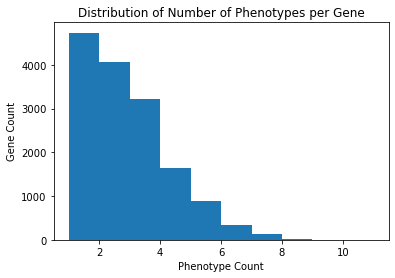

In [24]:
graph_phenotype_count_histogram(sorted_phenotype_ct_dict)

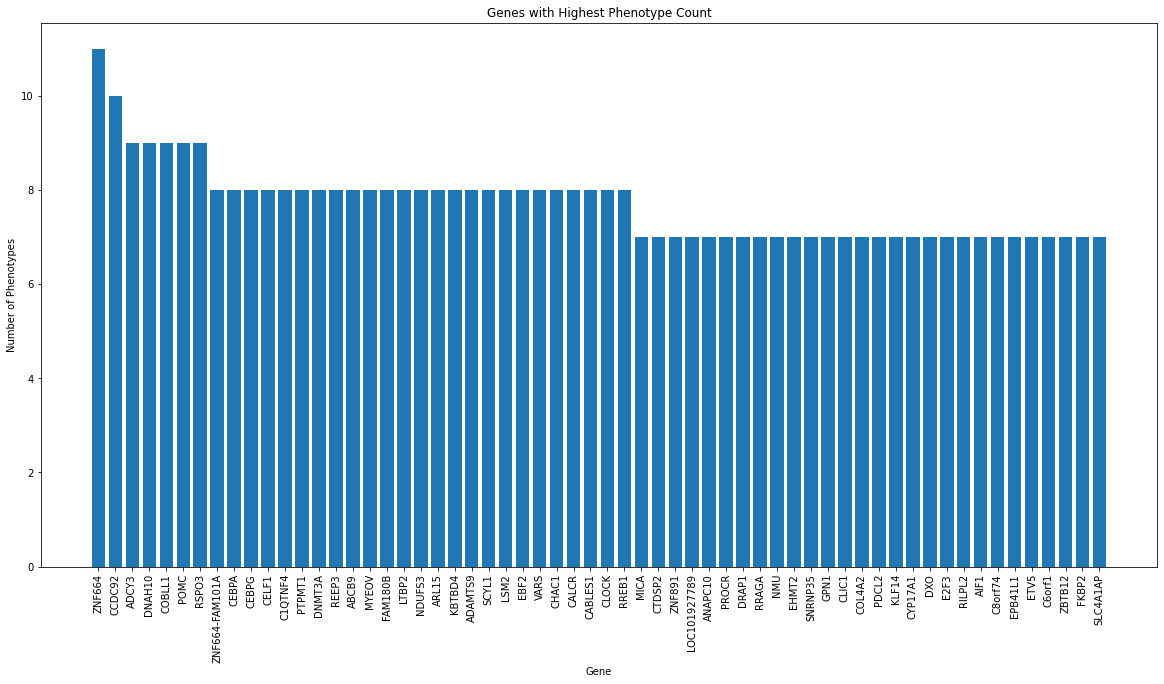

In [25]:
graph_gene_highest_phenotype_ct(sorted_phenotype_ct_dict, num_display=60)

In [26]:
phenotype_id_map = get_phenotype_id_map()
#phenotype_id_map

In [27]:
sorted_gene_dict = sort_data_dict(
    sort_dict=phenotype_ct_dict, content_dict=gene_dict, reverse=True
)

In [28]:
ordered_gene_df = generate_gene_data_df(sorted_gene_dict)
ordered_gene_df[:16]

,Gene,Count,Phenotype IDs,Phenotype Names,Unique Phenotype Groups,Phenotype Groups
0,ZNF664,11,"[VATSATadjBMI, WHRadjBMI, WAISTadjBMI, VATadjB...",[Ratio visceral-subcutaneous adipose tissue vo...,"[LIPIDS, GLYCEMIC, ANTHROPOMETRIC]","[ANTHROPOMETRIC, ANTHROPOMETRIC, ANTHROPOMETRI..."
1,CCDC92,10,"[WHRadjBMI, WAISTadjBMI, VATadjBMI, T2DadjBMI,...","[Waist-hip ratio adj BMI, Waist circumference ...","[GLYCEMIC, ANTHROPOMETRIC]","[ANTHROPOMETRIC, ANTHROPOMETRIC, ANTHROPOMETRI..."
2,ADCY3,9,"[VATSATadjBMI, WHRadjBMI, WAISTadjBMI, VATadjB...",[Ratio visceral-subcutaneous adipose tissue vo...,"[LIPIDS, GLYCEMIC, ANTHROPOMETRIC]","[ANTHROPOMETRIC, ANTHROPOMETRIC, ANTHROPOMETRI..."
3,DNAH10,9,"[WHRadjBMI, WAISTadjBMI, VATadjBMI, T2DadjBMI,...","[Waist-hip ratio adj BMI, Waist circumference ...","[GLYCEMIC, ANTHROPOMETRIC]","[ANTHROPOMETRIC, ANTHROPOMETRIC, ANTHROPOMETRI..."
4,COBLL1,9,"[VATSATadjBMI, WHRadjBMI, WAISTadjBMI, T2DadjB...",[Ratio visceral-subcutaneous adipose tissue vo...,"[LIPIDS, GLYCEMIC, ANTHROPOMETRIC]","[ANTHROPOMETRIC, ANTHROPOMETRIC, ANTHROPOMETRI..."
5,POMC,9,"[VATSATadjBMI, WHRadjBMI, WAISTadjBMI, VATadjB...",[Ratio visceral-subcutaneous adipose tissue vo...,"[LIPIDS, GLYCEMIC, ANTHROPOMETRIC]","[ANTHROPOMETRIC, ANTHROPOMETRIC, ANTHROPOMETRI..."
6,RSPO3,9,"[VATSATadjBMI, WHRadjBMI, WAISTadjBMI, VATadjB...",[Ratio visceral-subcutaneous adipose tissue vo...,"[LIPIDS, GLYCEMIC, ANTHROPOMETRIC]","[ANTHROPOMETRIC, ANTHROPOMETRIC, ANTHROPOMETRI..."
7,ZNF664-FAM101A,8,"[WHRadjBMI, WAISTadjBMI, VATadjBMI, T2DadjBMI,...","[Waist-hip ratio adj BMI, Waist circumference ...","[GLYCEMIC, ANTHROPOMETRIC]","[ANTHROPOMETRIC, ANTHROPOMETRIC, ANTHROPOMETRI..."
8,CEBPA,8,"[WHRadjBMI, WAISTadjBMI, VATadjBMI, T2DadjBMI,...","[Waist-hip ratio adj BMI, Waist circumference ...","[GLYCEMIC, ANTHROPOMETRIC]","[ANTHROPOMETRIC, ANTHROPOMETRIC, ANTHROPOMETRI..."
9,CEBPG,8,"[WHRadjBMI, WAISTadjBMI, VATadjBMI, T2DadjBMI,...","[Waist-hip ratio adj BMI, Waist circumference ...","[GLYCEMIC, ANTHROPOMETRIC]","[ANTHROPOMETRIC, ANTHROPOMETRIC, ANTHROPOMETRI..."


In [29]:
ordered_gene_df.to_csv("generated_data/Most_Wanted_Genes.csv")

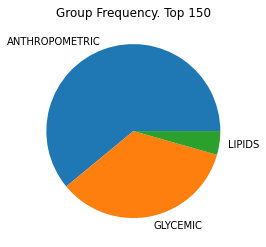

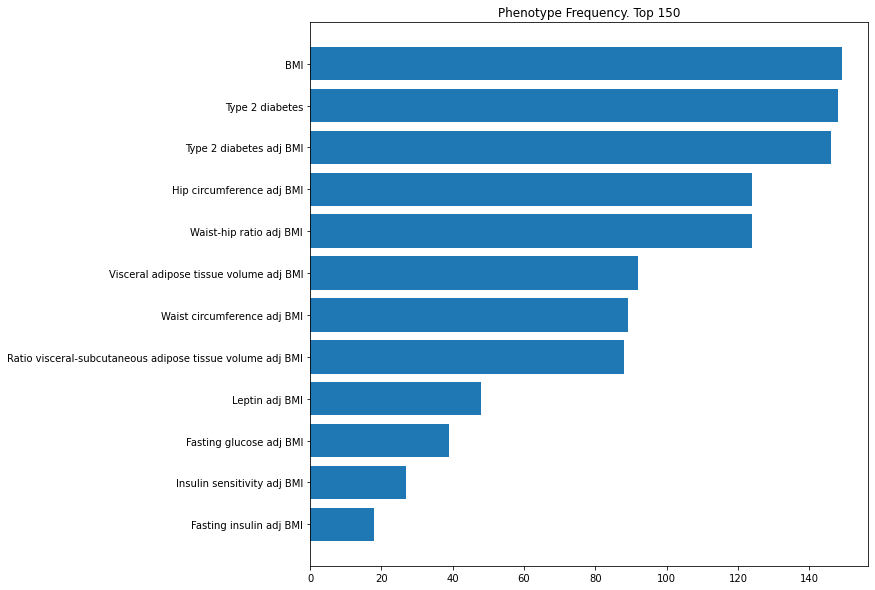

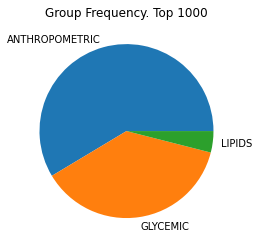

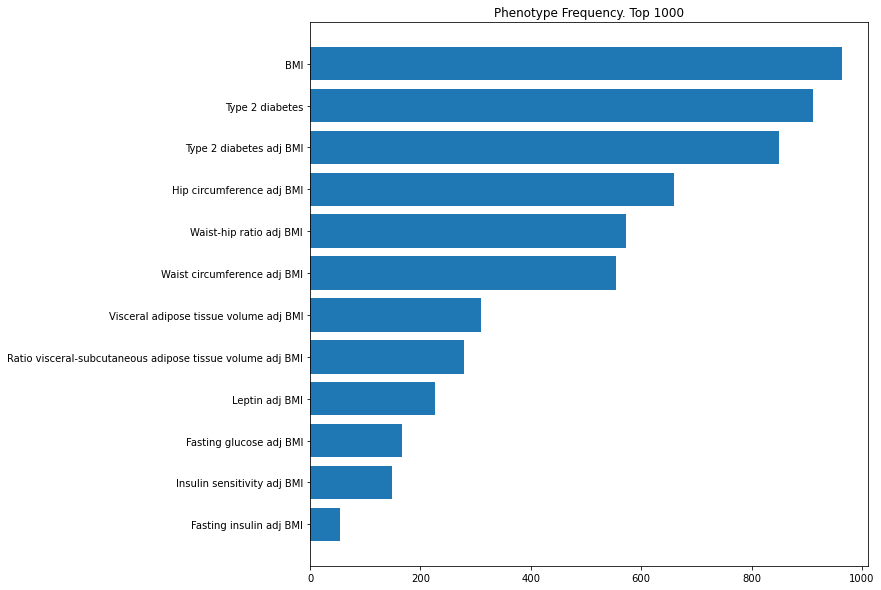

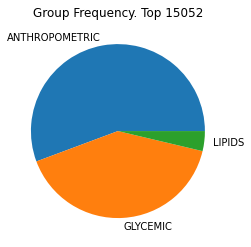

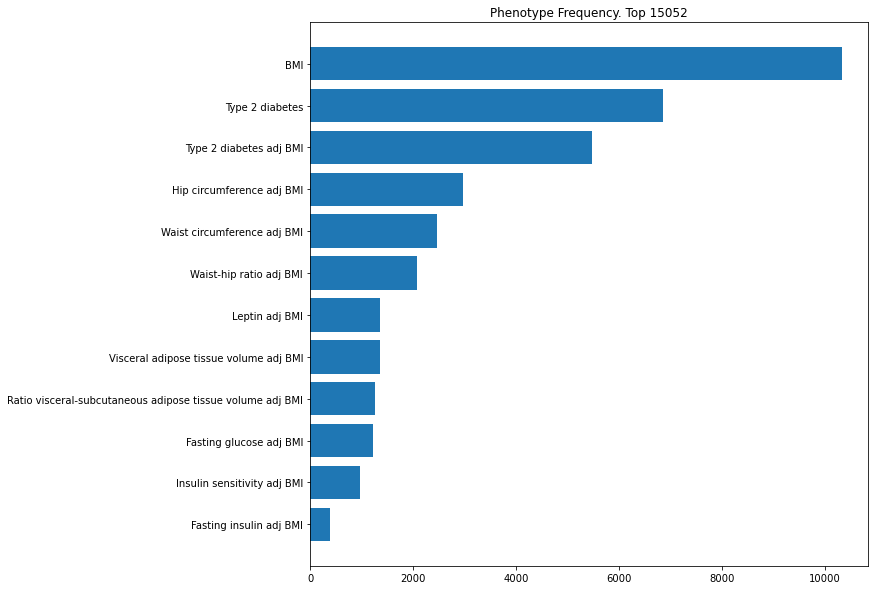

In [30]:
for count in [150, 1000, None]:
    graph_groups_ct_pie(ordered_gene_df, count)
    graph_phenotype_count_bar(ordered_gene_df, count)

In [31]:
#this is the new dataset the cross references the cillary and centriolar gene list 
ciliary_gene_df = filter_ciliary_only(ordered_gene_df)
ciliary_gene_df[:16]

,Gene,Count,Phenotype IDs,Phenotype Names,Unique Phenotype Groups,Phenotype Groups
0,CCDC92,10,"[WHRadjBMI, WAISTadjBMI, VATadjBMI, T2DadjBMI,...","[Waist-hip ratio adj BMI, Waist circumference ...","[GLYCEMIC, ANTHROPOMETRIC]","[ANTHROPOMETRIC, ANTHROPOMETRIC, ANTHROPOMETRI..."
1,ADCY3,9,"[VATSATadjBMI, WHRadjBMI, WAISTadjBMI, VATadjB...",[Ratio visceral-subcutaneous adipose tissue vo...,"[LIPIDS, GLYCEMIC, ANTHROPOMETRIC]","[ANTHROPOMETRIC, ANTHROPOMETRIC, ANTHROPOMETRI..."
2,DNAH10,9,"[WHRadjBMI, WAISTadjBMI, VATadjBMI, T2DadjBMI,...","[Waist-hip ratio adj BMI, Waist circumference ...","[GLYCEMIC, ANTHROPOMETRIC]","[ANTHROPOMETRIC, ANTHROPOMETRIC, ANTHROPOMETRI..."
3,ARL15,8,"[VATSATadjBMI, WAISTadjBMI, VATadjBMI, T2DadjB...",[Ratio visceral-subcutaneous adipose tissue vo...,"[LIPIDS, GLYCEMIC, ANTHROPOMETRIC]","[ANTHROPOMETRIC, ANTHROPOMETRIC, ANTHROPOMETRI..."
4,SCYL1,8,"[WHRadjBMI, WAISTadjBMI, VATadjBMI, T2DadjBMI,...","[Waist-hip ratio adj BMI, Waist circumference ...","[GLYCEMIC, ANTHROPOMETRIC]","[ANTHROPOMETRIC, ANTHROPOMETRIC, ANTHROPOMETRI..."
5,LSM2,8,"[WHRadjBMI, WAISTadjBMI, VATadjBMI, T2DadjBMI,...","[Waist-hip ratio adj BMI, Waist circumference ...","[GLYCEMIC, ANTHROPOMETRIC]","[ANTHROPOMETRIC, ANTHROPOMETRIC, ANTHROPOMETRI..."
6,VARS,8,"[WHRadjBMI, WAISTadjBMI, VATadjBMI, T2DadjBMI,...","[Waist-hip ratio adj BMI, Waist circumference ...","[GLYCEMIC, ANTHROPOMETRIC]","[ANTHROPOMETRIC, ANTHROPOMETRIC, ANTHROPOMETRI..."
7,CLIC1,7,"[WHRadjBMI, VATadjBMI, T2DadjBMI, HIPCadjBMI, ...","[Waist-hip ratio adj BMI, Visceral adipose tis...","[GLYCEMIC, ANTHROPOMETRIC]","[ANTHROPOMETRIC, ANTHROPOMETRIC, GLYCEMIC, ANT..."
8,RILPL2,7,"[WHRadjBMI, WAISTadjBMI, T2DadjBMI, HIPCadjBMI...","[Waist-hip ratio adj BMI, Waist circumference ...","[GLYCEMIC, ANTHROPOMETRIC]","[ANTHROPOMETRIC, ANTHROPOMETRIC, GLYCEMIC, ANT..."
9,EPB41L1,7,"[WHRadjBMI, WAISTadjBMI, T2DadjBMI, HIPCadjBMI...","[Waist-hip ratio adj BMI, Waist circumference ...","[GLYCEMIC, ANTHROPOMETRIC]","[ANTHROPOMETRIC, ANTHROPOMETRIC, GLYCEMIC, ANT..."


In [32]:
cilliary_gene_dict = generate_cilliary_gene_dict(ciliary_gene_df)
#cilliary_gene_dict

In [33]:
ciliary_gene_df.to_csv("generated_data/Ciliary_and_Centriolar_Most_Wanted_Genes.csv")

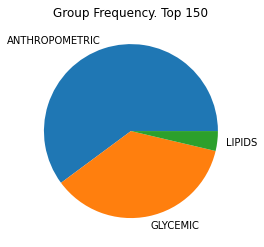

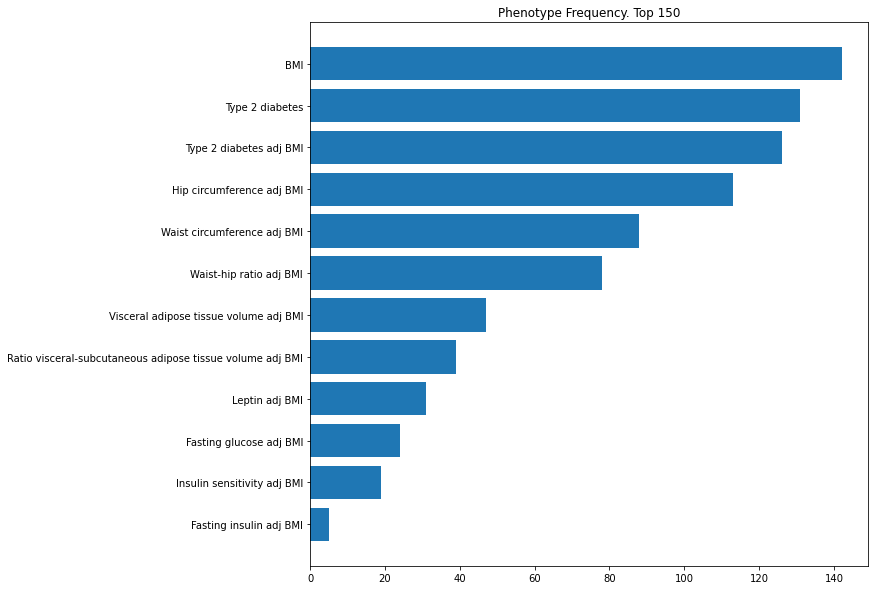

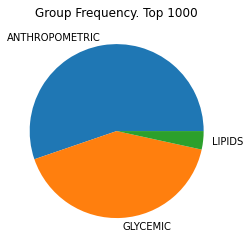

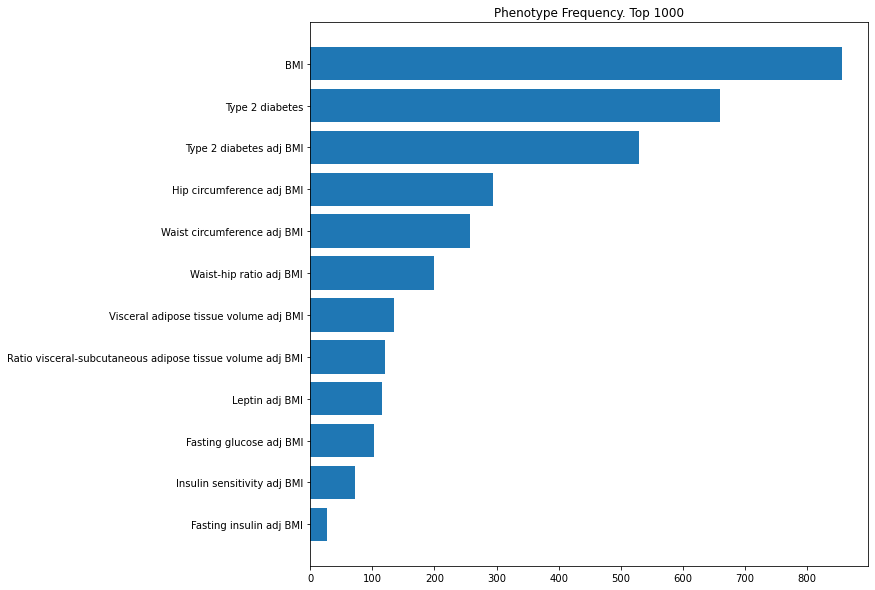

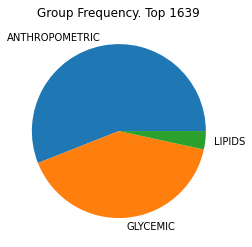

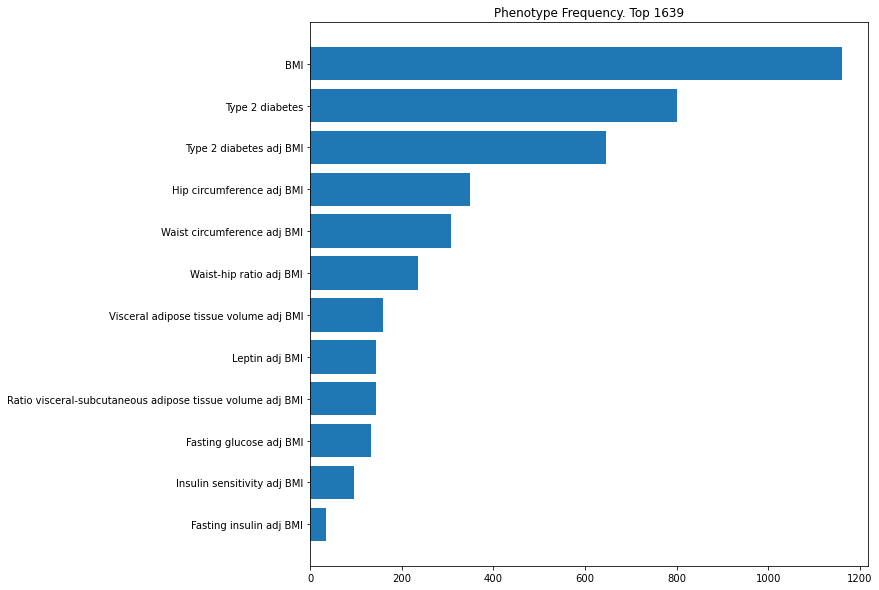

In [35]:
for count in [150, 1000, None]:
    graph_groups_ct_pie(ciliary_gene_df, count)
    graph_phenotype_count_bar(ciliary_gene_df, count)

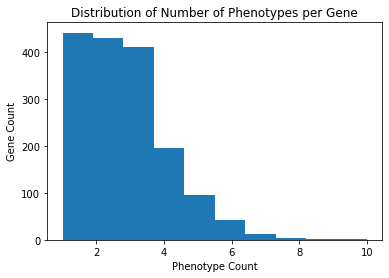

In [36]:
graph_phenotype_count_histogram(cilliary_gene_dict)

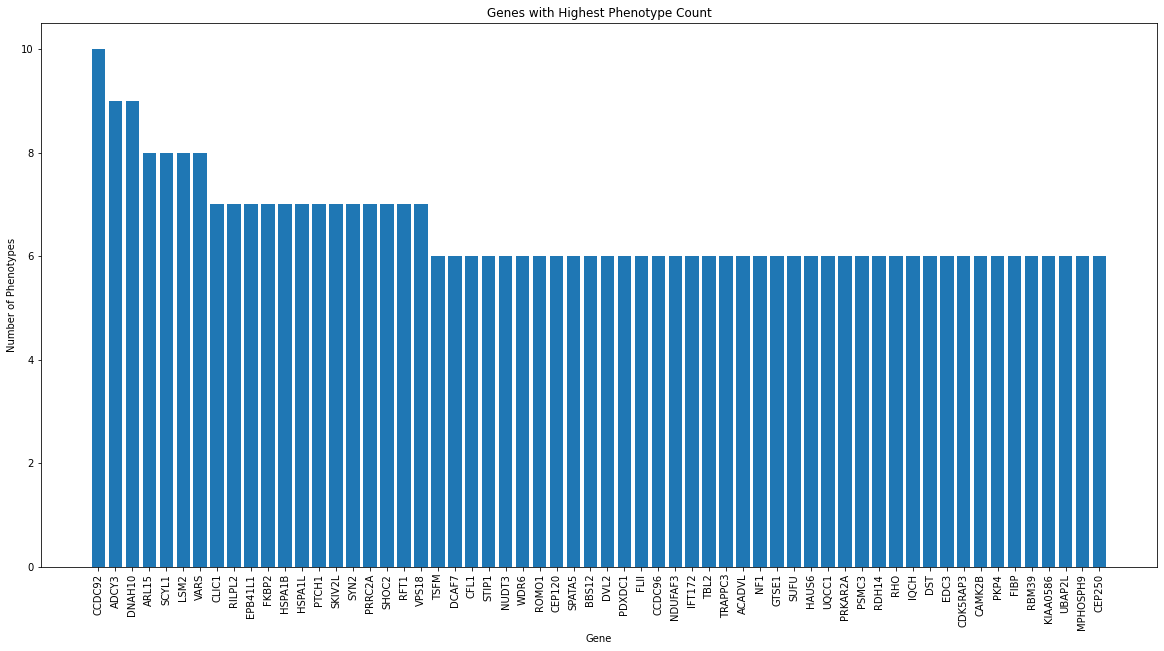

In [37]:
graph_gene_highest_phenotype_ct(cilliary_gene_dict, num_display=60)